In [1]:
# https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.insert(1, '../../python_scripts')
from fourier import *

## The signal ( a pulse signal)

In [2]:
# Function that equals 1 at 0 and is null elsewhere
def pulse(t):
    if t == 0:
        return 1
    else:
        return 0
    
func = pulse

In [3]:
# Arguments
dt = .01 # dt : sample spacing 
N = 100 # sample size (N/2 is the number the positive frequencies)

x, T = construct_discrete_signal_starting_from_0(dt, N, func)

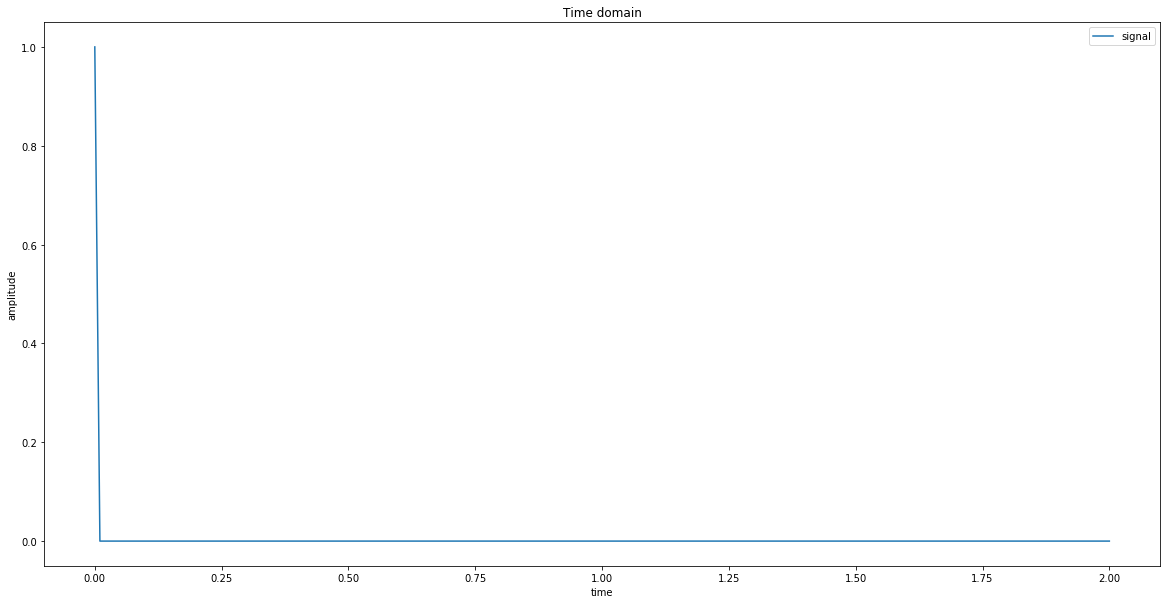

In [4]:
# Arguments
Xs = [T]
L = [x]
Labels = ["signal"]
title = "Time domain"
xLabel = "time"
yLabel = "amplitude"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)

## IDFT using array returned by np.fft.ifft

In [5]:
X_noshift, Xi, X = retrieve_frequencies(x, N, dt)
X = X/(2*N)
Freqs = Xi

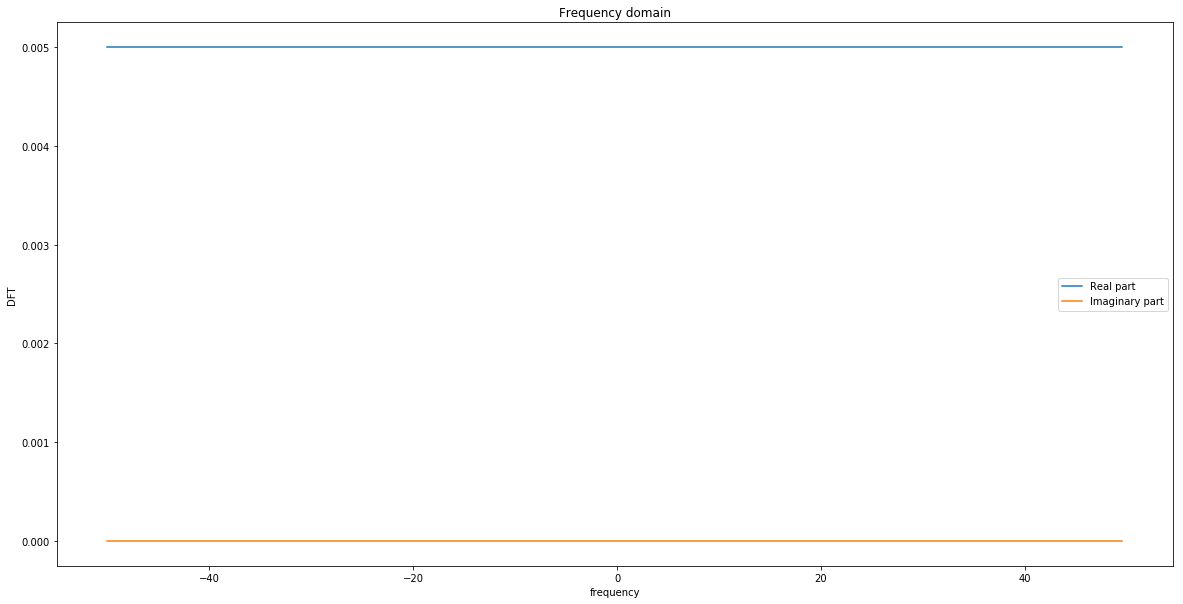

In [6]:
# Arguments
Xs = [Xi, Xi]
L = [np.real(X), np.imag(X)]
Labels = ["Real part", "Imaginary part"]
title = "Frequency domain"
xLabel = "frequency"
yLabel = "DFT"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)

In [7]:
recovered_x = np.fft.ifft(X_noshift) # IDFT
error = np.abs(recovered_x.real - x) # we also compute the error between the original signal and the one returned by the IDFT

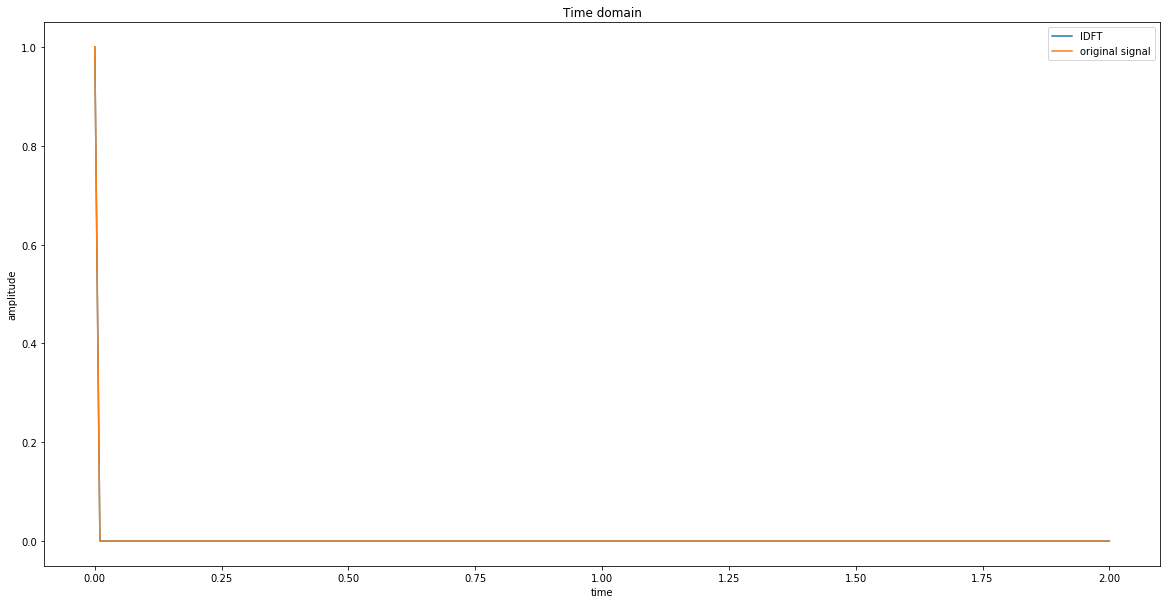

In [8]:
# Arguments
Xs = [T, T]
L = [recovered_x.real, x]
Labels = ["IDFT", "original signal"]
title = "Time domain"
xLabel = "time"
yLabel = "amplitude"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)

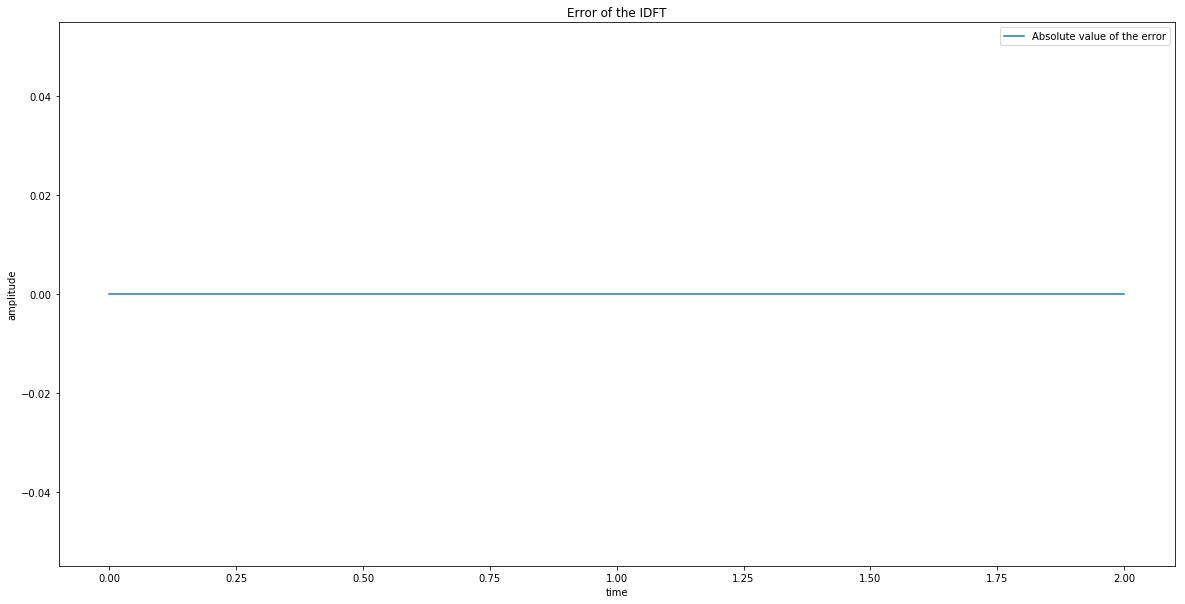

Maximum value of the error :  0.0


In [9]:
# Arguments
Xs = [T]
L = [error]
Labels = ["Absolute value of the error"]
title = "Error of the IDFT"
xLabel = "time"
yLabel = "amplitude"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)
print("Maximum value of the error : ", np.amax(error))

## NUDFT ?

The NUDFT-I corresponds to uniform sample points $p_n = \frac{n}{N}$ and non-uniform frequencies $f_k \in [0, \cdots, N]$.
$$ X(z_k)=X_k = \sum_{n=0}^{N-1} x_n e^{-2\pi i p_n f_k} = \sum_{n=0}^{N-1} x_n e^{-2\pi i \frac{n}{N} f_k} = \sum_{n=0}^{N-1}x[n]z_k^{n},\quad k=0, 1, ..., N-1, $$

where $z_k = e^{- 2\pi i  \frac{f_k}{N}}$.
$$
\mathbf{X}=\begin{bmatrix}
 X(z_0)\\
 X(z_1)\\
 \vdots\\
 X(z_{N-1})
\end{bmatrix},\quad
\mathbf{x}=\begin{bmatrix}
 x[0]\\
 x[1]\\
 \vdots\\
 x[N-1]
\end{bmatrix},\text{ and}\quad
\mathbf{D}=\begin{bmatrix}
 1 & z_0^{-1} & z_0^{-2} & \cdots & z_0^{-(N-1)}\\
 1 & z_1^{-1} & z_1^{-2} & \cdots & z_1^{-(N-1)}\\
 \vdots & \vdots & \vdots & \ddots & \vdots\\
 1 & z_{N-1}^{-1} & z_{N-1}^{-2} & \cdots & z_{N-1}^{-(N-1)}
\end{bmatrix}.
$$

We have 

$$ X = D x $$

and we can express $x$ as 

$$ x = D^{- 1} X $$

In [10]:
X_filled_with_1s = np.ones(len(Freqs)) # Our amplitudes, all equal to 1 

In [11]:
# https://en.wikipedia.org/wiki/Non-uniform_discrete_Fourier_transform#Direct_inversion_of_the_NUDFT-I
def get_D(F):
    N = F.shape[0]
    D = np.empty((N, N), dtype = np.complex128)
    for k in range(N):
        f = F[k]
        z = np.exp(- 2*np.pi*1j*f/N)
        for n in range(N):
            D[k, n] = z**n
    return D

### NUDFT with regular sampling

In [12]:
Freqs_normalized = Freqs*(2*dt*N)
D = get_D(Freqs_normalized)
invD = np.linalg.inv(D)
x_test = np.dot(invD, X_filled_with_1s)

In [13]:
print("Determinant of D : ", np.linalg.det(D))
print("Determinant of D^{-1} : ", np.linalg.det(invD) )
print("Determinant of D.D^{-1} : ", np.linalg.det( np.dot(D, invD) ) )

Determinant of D :  (-1.6219995532949402e+216-1.2676506002280613e+230j)
Determinant of D^{-1} :  (-8.407790785950972e-245+7.888609052212046e-231j)
Determinant of D.D^{-1} :  (1.0000000000000266-2.88679832064699e-15j)


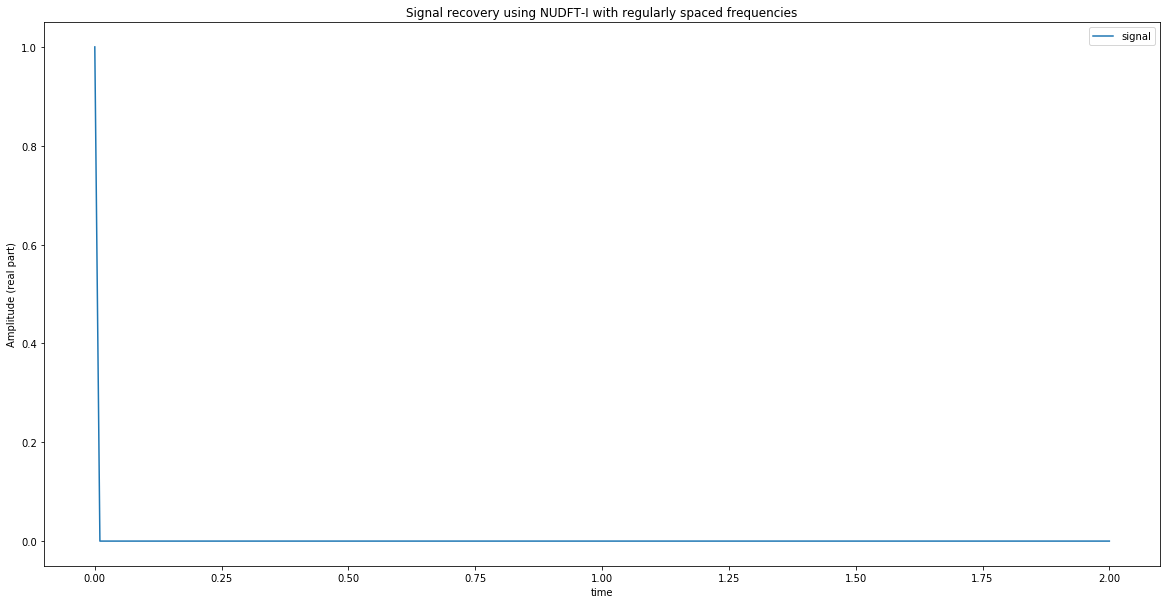

In [14]:
# Arguments
Xs = [T]
L = [x_test.real]
Labels = ["signal"]
title = "Signal recovery using NUDFT-I with regularly spaced frequencies"
xLabel = "time"
yLabel = "Amplitude (real part)"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)

### NUDFT with irregular sampling (custom)

In [15]:
Freqs_custom_normalized = np.concatenate((np.linspace(.1, N - .35, N//2), np.linspace(.75, N , (N + 1)//2)))
Freqs_custom_normalized = np.concatenate(( - Freqs_custom_normalized, Freqs_custom_normalized))
Freqs_custom = Freqs_custom_normalized/(2*N*dt)

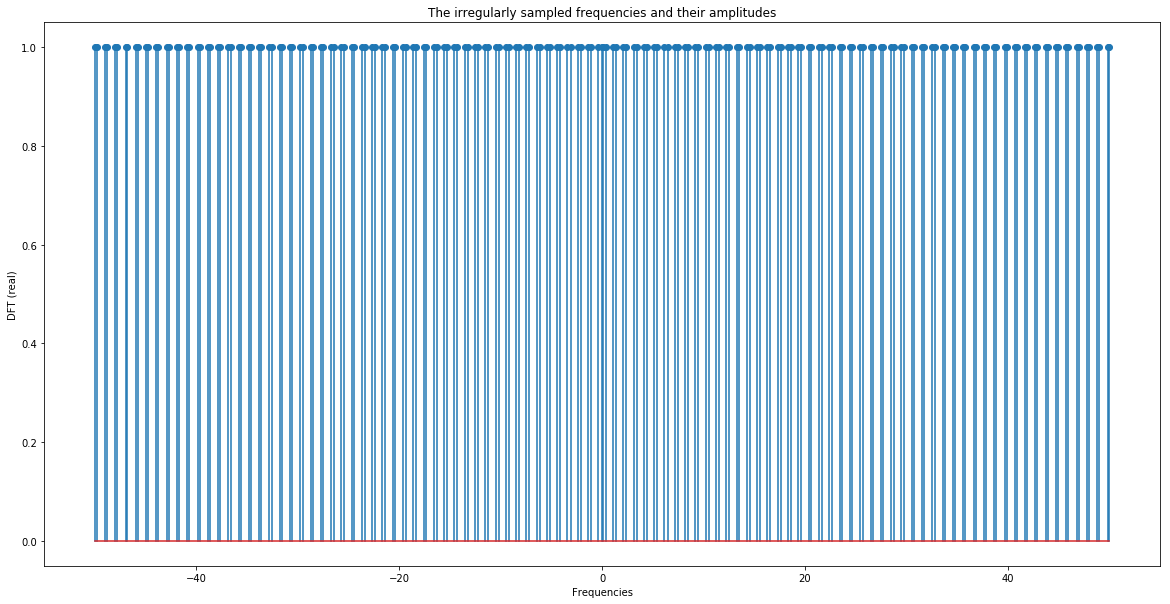

In [16]:
plt.figure(figsize = (20, 10))
plt.title("The irregularly sampled frequencies and their amplitudes")
plt.stem(Freqs_custom, X_filled_with_1s)
plt.xlabel("Frequencies")
plt.ylabel("DFT (real)")
plt.show()

In [17]:
D_custom = get_D(Freqs_custom_normalized)
inv_D_custom = np.linalg.inv(D_custom)
x_custom = np.dot(inv_D_custom, X_filled_with_1s)

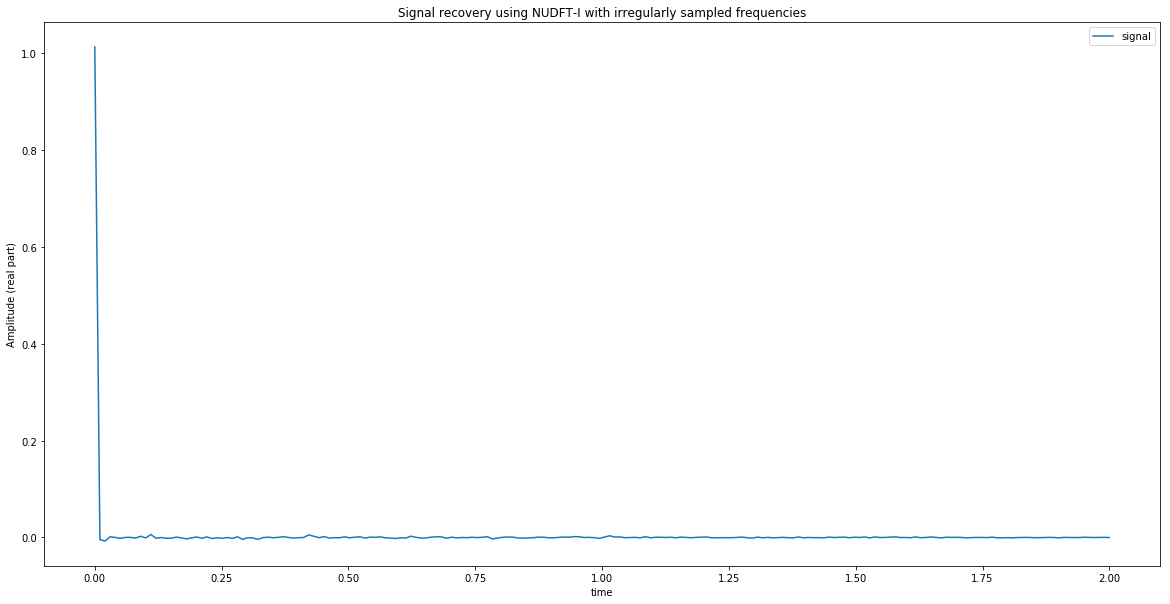

In [18]:
# Arguments
Xs = [T]
L = [x_custom.real]
Labels = ["signal"]
title = "Signal recovery using NUDFT-I with irregularly sampled frequencies"
xLabel = "time"
yLabel = "Amplitude (real part)"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)

### NUDFT with randomly sampled frequencies ( uniform distribution)

In [19]:
Freqs_random_normalized = np.random.uniform(0, N, N)
Freqs_random_normalized = np.concatenate((- Freqs_random_normalized, Freqs_random_normalized))
Freqs_random_normalized = np.sort( Freqs_random_normalized )
Freqs_random = Freqs_random_normalized/(2*N*dt)

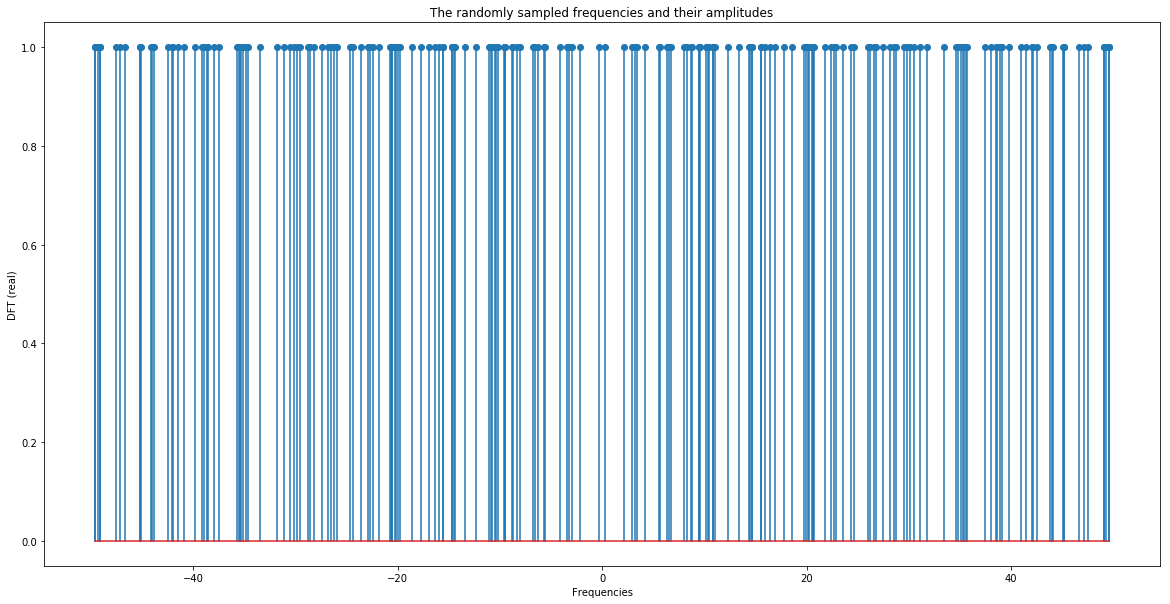

In [20]:
plt.figure(figsize = (20, 10))
plt.title("The randomly sampled frequencies and their amplitudes")
plt.stem(Freqs_random, X_filled_with_1s)
plt.xlabel("Frequencies")
plt.ylabel("DFT (real)")
plt.show()

In [21]:
D_random = get_D(Freqs_random_normalized)
inv_D_random = np.linalg.inv(D_random)
x_random = np.dot(D_random, X_filled_with_1s)

In [22]:
print("Determinant of D : ", np.linalg.det(D_random))
print("Determinant of D^{-1} : ", np.linalg.det(inv_D_random) )
print("Determinant of D.D^{-1} : ", np.linalg.det( np.dot(D_random, inv_D_random) ) )

Determinant of D :  (2.1577880360211172e+83+3.4976672867333684e+79j)
Determinant of D^{-1} :  (4.634851529694978e-84-6.49656753219667e-88j)
Determinant of D.D^{-1} :  (1.0001192181731822-0.0001285183882906927j)


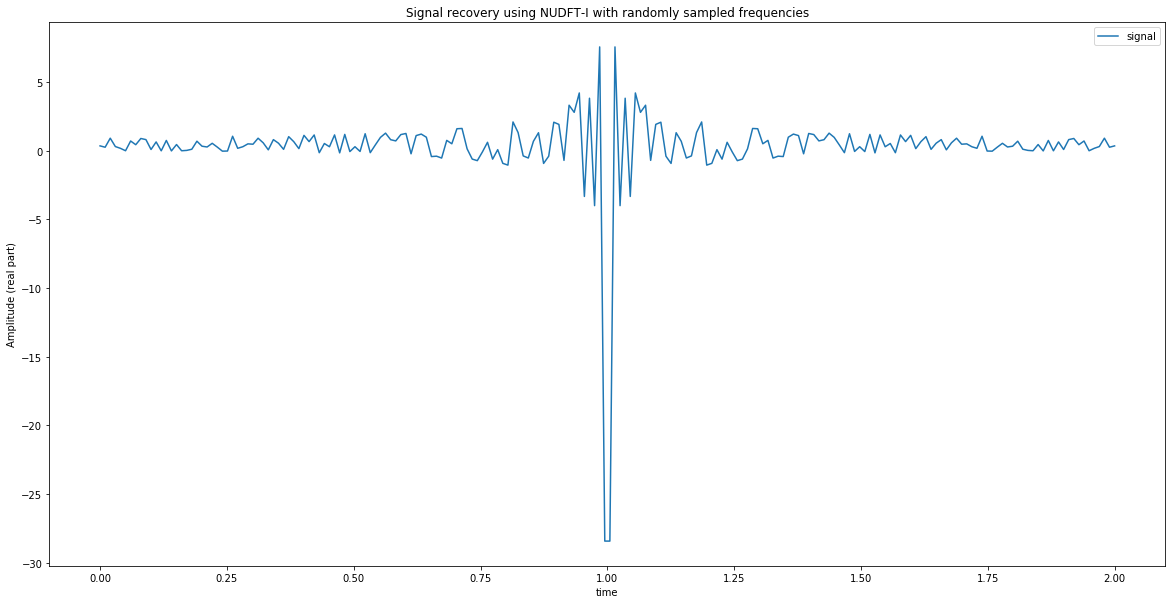

In [23]:
# Arguments
Xs = [T]
L = [x_random.real]
Labels = ["signal"]
title = "Signal recovery using NUDFT-I with randomly sampled frequencies"
xLabel = "time"
yLabel = "Amplitude (real part)"

plot_signals(Xs, L, Labels, title, xLabel, yLabel)